In [3]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
df=pd.read_csv("dataset/ev_battery_charging_data.csv")

In [5]:
print(df.columns)

Index(['SOC (%)', 'Voltage (V)', 'Current (A)', 'Battery Temp (°C)',
       'Ambient Temp (°C)', 'Charging Duration (min)', 'Degradation Rate (%)',
       'Charging Mode', 'Efficiency (%)', 'Battery Type', 'Charging Cycles',
       'EV Model', 'Optimal Charging Duration Class'],
      dtype='object')


In [6]:
df.head()

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Duration (min),Degradation Rate (%),Charging Mode,Efficiency (%),Battery Type,Charging Cycles,EV Model,Optimal Charging Duration Class
0,43.708611,3.629593,33.553512,33.454060,26.439918,59.363552,8.805096,Fast,98.238981,Li-ion,112,Model B,1
1,95.564288,3.879331,32.228092,35.933628,31.108647,67.343566,12.186860,Fast,97.562628,LiFePO4,398,Model A,1
2,75.879455,4.111062,91.562912,25.009358,30.203219,105.454739,13.832336,Slow,97.233533,LiFePO4,175,Model A,2
3,63.879264,4.012557,32.459158,32.497482,18.077998,54.000439,9.318874,Fast,98.136225,LiFePO4,150,Model B,1
4,24.041678,4.064593,34.475475,31.434920,17.984989,106.964968,11.687577,Fast,97.662485,Li-ion,886,Model C,2


In [7]:
df.isnull().sum()

SOC (%)                            0
Voltage (V)                        0
Current (A)                        0
Battery Temp (°C)                  0
Ambient Temp (°C)                  0
Charging Duration (min)            0
Degradation Rate (%)               0
Charging Mode                      0
Efficiency (%)                     0
Battery Type                       0
Charging Cycles                    0
EV Model                           0
Optimal Charging Duration Class    0
dtype: int64

In [8]:
dup=df[df.duplicated()]
print(dup)

Empty DataFrame
Columns: [SOC (%), Voltage (V), Current (A), Battery Temp (°C), Ambient Temp (°C), Charging Duration (min), Degradation Rate (%), Charging Mode, Efficiency (%), Battery Type, Charging Cycles, EV Model, Optimal Charging Duration Class]
Index: []


In [9]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median(skipna=True))

In [10]:
print("Dataset is cleaned")
df.head()

Dataset is cleaned


,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Duration (min),Degradation Rate (%),Charging Mode,Efficiency (%),Battery Type,Charging Cycles,EV Model,Optimal Charging Duration Class
0,43.708611,3.629593,33.553512,33.454060,26.439918,59.363552,8.805096,Fast,98.238981,Li-ion,112,Model B,1
1,95.564288,3.879331,32.228092,35.933628,31.108647,67.343566,12.186860,Fast,97.562628,LiFePO4,398,Model A,1
2,75.879455,4.111062,91.562912,25.009358,30.203219,105.454739,13.832336,Slow,97.233533,LiFePO4,175,Model A,2
3,63.879264,4.012557,32.459158,32.497482,18.077998,54.000439,9.318874,Fast,98.136225,LiFePO4,150,Model B,1
4,24.041678,4.064593,34.475475,31.434920,17.984989,106.964968,11.687577,Fast,97.662485,Li-ion,886,Model C,2


In [127]:
label_encoders = {}
categorical_columns = ['Charging Mode', 'Battery Type', 'EV Model']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['Optimal Charging Duration Class'])
y = df['Optimal Charging Duration Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

noise = np.random.normal(0, 0.15, X_train.shape)
X_train_noisy = X_train + noise

model = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=10, class_weight="balanced", random_state=42)
model.fit(X_train_noisy, y_train)

y_pred = model.predict(X_test)

with open("model/model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

np.save("model/y_test.npy", y_test)
np.save("model/y_pred.npy", y_pred)

In [128]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

metrics = {"accuracy": accuracy}
with open("model/metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

Model Accuracy: 95.33%


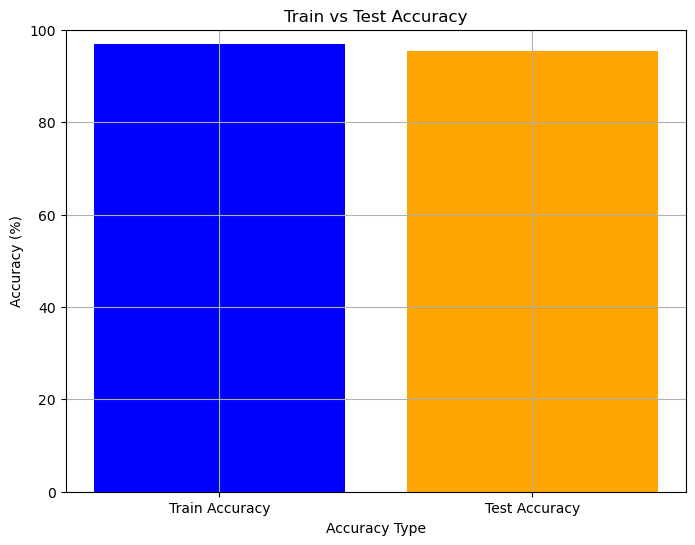

In [129]:
y_train_true = y_train
y_pred_train = model.predict(X_train)

y_test_true = y_test
y_pred_test = y_pred

train_accuracy = accuracy_score(y_train_true, y_pred_train) * 100
test_accuracy = accuracy_score(y_test_true, y_pred_test) * 100

categories = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy, test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=['blue', 'orange'])
plt.xlabel('Accuracy Type')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

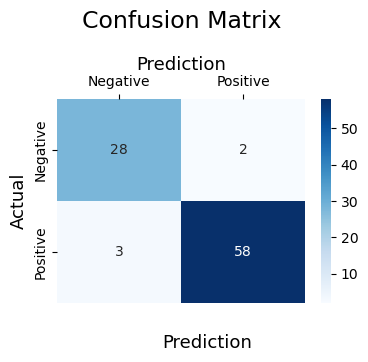

In [132]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()

plt.figure(figsize=(4, 3))
sns.heatmap(cm, 
            annot=True, 
            fmt='g', 
            cmap="Blues", 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.savefig("static/confusion_matrix.png", bbox_inches="tight")
plt.show()

np.save("model/y_test.npy", y_test)
np.save("model/y_pred.npy", y_pred)